<span style="background: linear-gradient(90deg, #2b5876, #4e4376); -webkit-background-clip: text; -webkit-text-fill-color: transparent; font-family: 'Arial', sans-serif; font-weight: 700; letter-spacing: 1px; padding: 10px 0; display: inline-block; font-size: 1.8em; text-shadow: 0px 2px 4px rgba(0,0,0,0.1);">🎬 An Interpretable Machine Learning Pipeline<br><span style="font-size: 0.9em;">for Forecasting Movie Success</span></span>
<div style="border-top: 2px solid #4e4376; width: 80%; margin: 10px 0;"></div>

### **Configuration**

In [1]:
import logging
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance 
from sklearn.metrics import mean_squared_error

# ML Libraries
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

# Interpretation & Tuning
import shap
import optuna
import optuna.logging # For silencing logs

# Utilities
from tqdm import tqdm 


c:\Users\divya\anaconda3\envs\model_development\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### **Retrive fianlized cleaned data**

In [2]:
d = './raw_data/'
with open(r'C:\Users\divya\OneDrive\Documents\GitHub\spring-2025-greenlight\processed_data\dummy_data.pkl', 'rb') as filename:  
    df = pickle.load(filename)

#### **Variable Transformations**

In [3]:
features = ['director_1_budget_efficiency',
            'actor_1_budget_efficiency',
            'director_max_rating_performance',
            'actor_max_rating_performance',
            'adjusted_budget',
            'production_efficiency_score']
print(df[features].min())

director_1_budget_efficiency           0.162549
actor_1_budget_efficiency              0.049711
director_max_rating_performance        5.000000
actor_max_rating_performance           3.189531
adjusted_budget                    13702.168596
production_efficiency_score            0.202467
dtype: float64


##### since the feautres considered  for transformation is strictly positve, it is safe to do the logrithmic transformation

In [4]:
df['success_ratio'] = np.log((df['adjusted_worldwide_boxoffice'] / df['adjusted_budget'])) #wroi
for feature in features:
    df[f"{feature}_log"] = np.log(df[feature])

#### **Variable Definitions**

In [5]:
numeric_features = ['adjusted_budget_log', 'runtime', 
                   'director_max_rating_performance_log', 'director_1_budget_efficiency_log',
                   'actor_max_rating_performance_log', 'actor_1_budget_efficiency_log','production_efficiency_score_log','content_coherence','sentiment']

categorical_features = ['is_drama', 'is_comedy', 'is_action', 'is_thriller', 
                        'is_adventure', 'is_romance', 'is_crime', 'is_science_fiction', 
                        'is_horror', 'is_family']

features = [
    'adjusted_budget_log', 
    'runtime', 
    'director_1_budget_efficiency_log', 
    'actor_1_budget_efficiency_log',
    'director_max_rating_performance_log',
    'actor_max_rating_performance_log',
    'production_efficiency_score_log',
    'content_coherence','sentiment',
    'is_drama',
    'is_comedy',
    'is_action',
    'is_thriller',
    'is_adventure',
    'is_romance',
    'is_crime',
    'is_science_fiction',
    'is_horror',
    'is_family'
]

### **Exploratory Data Analysis**

##### **Target Variable**

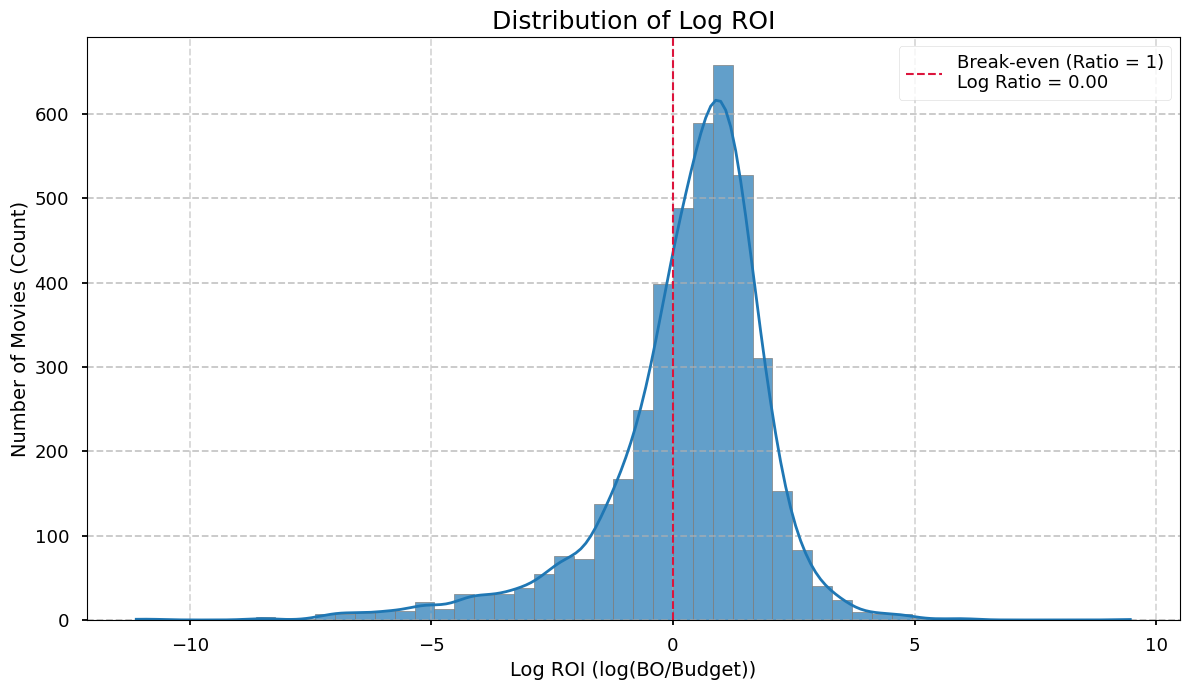

In [6]:
plt.style.use('seaborn-v0_8-talk') 

plt.figure(figsize=(12, 7)) 
sns.histplot(data=df, x='success_ratio', bins=50, kde=True,
             edgecolor='grey', linewidth=0.5, alpha=0.7,
             line_kws={'linewidth': 2}) 

plt.title('Distribution of Log ROI', fontsize=18)
plt.xlabel('Log ROI (log(BO/Budget))', fontsize=14)
plt.ylabel('Number of Movies (Count)', fontsize=14)
plt.axvline(x=0, color='crimson', linestyle='--', linewidth=1.5,
            label=f'Break-even (Ratio = 1)\nLog Ratio = {0:.2f}')

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##### **Explanatory Variables**

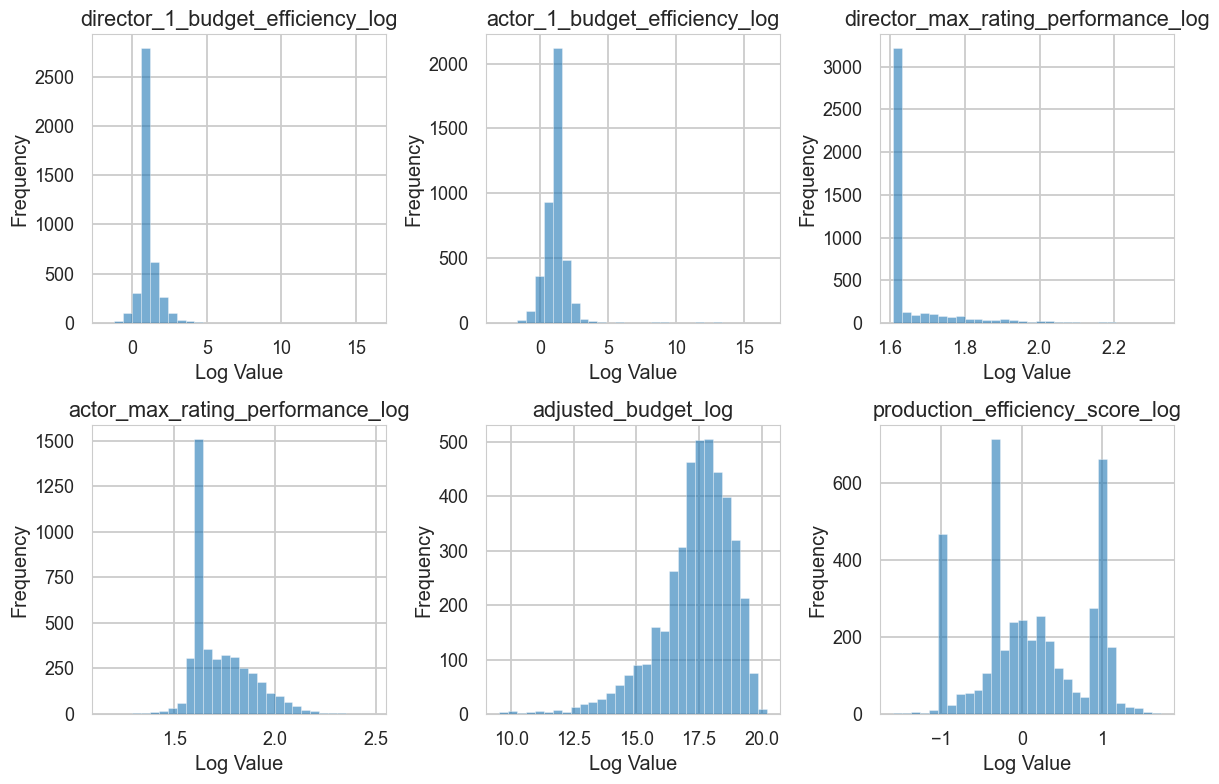

In [26]:

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

features = ['director_1_budget_efficiency',
            'actor_1_budget_efficiency',
            'director_max_rating_performance',
            'actor_max_rating_performance',
            'adjusted_budget',
            'production_efficiency_score']

for i, feature in enumerate(features):
    data = df[f"{feature}_log"].replace([np.inf, -np.inf], np.nan).dropna()
    axes[i].hist(data, bins=30, alpha=0.6)
    axes[i].set_title(f"{feature}_log")
    axes[i].set_xlabel("Log Value")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


##### Relationship between the target variable  & the explanatory variables

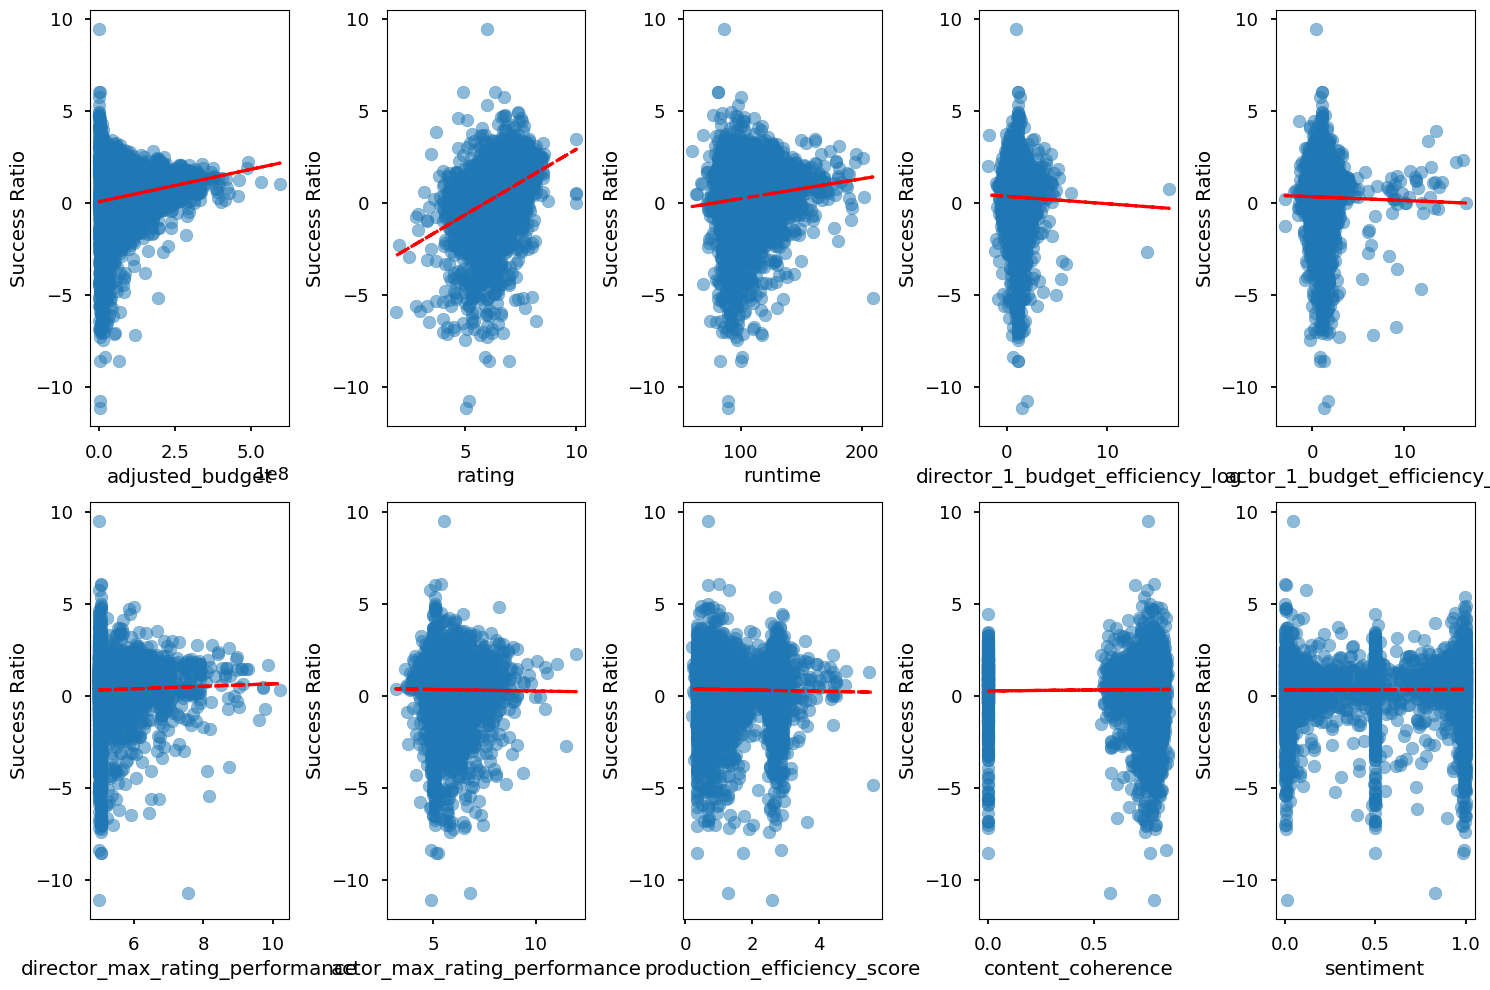

In [ ]:
features = ['adjusted_budget', 'rating', 'runtime', 
            'director_1_budget_efficiency_log', 'actor_1_budget_efficiency_log',
            'director_max_rating_performance',
            'actor_max_rating_performance','production_efficiency_score','content_coherence','sentiment']

fig, axes = plt.subplots(2, 5, figsize=(15, 10))
axes = axes.flatten() 

for i, feature in enumerate(features):
    ax = axes[i]
    
    df_clean = df.dropna(subset=[feature, 'success_ratio'])
    df_clean = df_clean[
        np.isfinite(df_clean[feature]) & 
        np.isfinite(df_clean['success_ratio'])
    ]
    
    x = df_clean[feature]
    y = df_clean['success_ratio']
    ax.scatter(x, y, alpha=0.5)
    ax.set_xlabel(feature)
    ax.set_ylabel('Success Ratio')
    
    if len(x) > 1:
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        ax.plot(x, p(x), "r--")

if len(features) < len(axes):
    for j in range(len(features), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##### **Correlation plot**

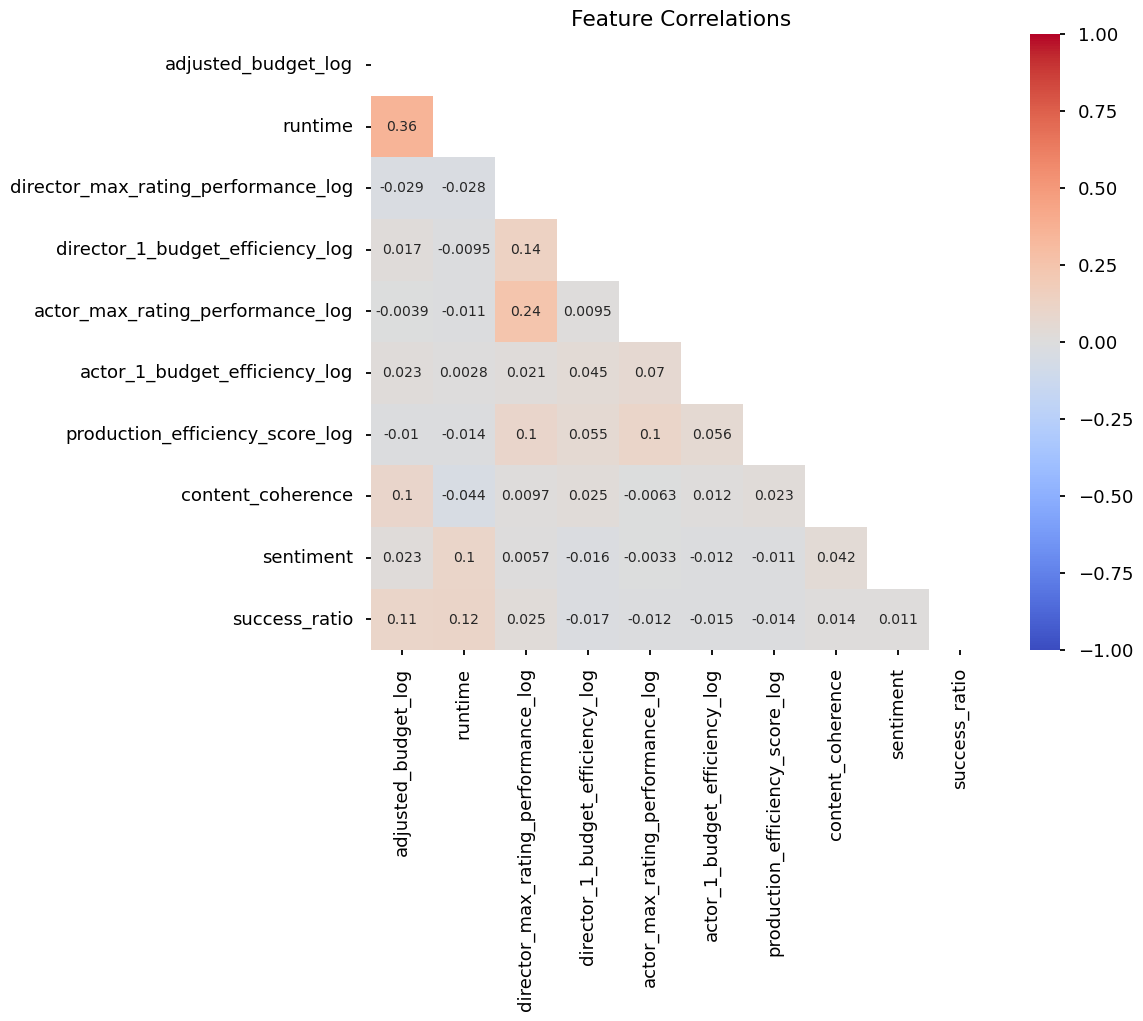

In [ ]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[numeric_features + ['success_ratio']].corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlations')
plt.show()

### **Modelling Pipeline**
<div style="border-bottom: 2px solid #5499C7; width: 100%; margin-bottom: 15px;"></div>
<span style="color: #2471A3; font-family: 'Georgia', serif;">Motivation & Approach</span>
<div style="background-color: #F8F9F9; border-left: 4px solid #3498DB; padding: 15px; margin: 15px 0;">
We built a pipeline for the entire modeling strategy because it enables <strong>systematic comparison</strong> of multiple algorithms (RandomForest, XGBoost, LightGBM, CatBoost, SVR) without duplicating preprocessing code, while enforcing consistent evaluation metrics across all experiments.
</div>
Our modular design, with separate functions for:
<div style="background-color: #EBF5FB; padding: 12px; border-radius: 4px; margin-left: 20px;">
<ul style="list-style-type: square; color: #2E86C1;">
  <li><span style="color: #34495E; font-weight: 500;">Data splitting</span></li>
  <li><span style="color: #34495E; font-weight: 500;">Preprocessing</span></li>
  <li><span style="color: #34495E; font-weight: 500;">Hyperparameter tuning</span></li>
  <li><span style="color: #34495E; font-weight: 500;">Base Models</span></li>
  <li><span style="color: #34495E; font-weight: 500;">Ensemble creation</span></li>
</ul>
</div>
<div style="margin-top: 15px; font-family: 'Georgia', serif; color: #2C3E50;">
accelerates experimentation cycles and ensures reproducibility when sharing findings with stakeholders.
</div>

<span style="color: #2471A3; font-family: 'Georgia', serif; margin-top: 20px; display: block;">Base Models</span>
<div style="background-color: #F8F9F9; border-left: 4px solid #3498DB; padding: 15px; margin: 15px 0;">
We selected a diverse set of algorithms to capture different modeling strengths for predicting box office performance. In the base model setup we are including the Lasso Regression and KNN Regression we used in the  variable exploration step in the regression buiding notebook for comparison (we are not using them in the ensemble model).
</div>

<div style="display: grid; grid-template-columns: repeat(auto-fit, minmax(300px, 1fr)); gap: 15px; margin-top: 15px;">
  <div style="background-color: #EBF5FB; padding: 15px; border-radius: 4px; border-top: 3px solid #3498DB;">
    <h4 style="color: #2E86C1; margin-top: 0;">Random Forest</h4>
    <p style="color: #34495E; margin-bottom: 0;">An ensemble of decision trees that handles non-linear relationships and feature interactions well. Less prone to overfitting and provides built-in feature importance metrics.</p>
  </div>
  
  <div style="background-color: #EBF5FB; padding: 15px; border-radius: 4px; border-top: 3px solid #3498DB;">
    <h4 style="color: #2E86C1; margin-top: 0;">XGBoost</h4>
    <p style="color: #34495E; margin-bottom: 0;">Gradient boosting implementation that sequentially builds trees to correct previous errors. Excellent performance with regularization techniques to prevent overfitting.</p>
  </div>
  
  <div style="background-color: #EBF5FB; padding: 15px; border-radius: 4px; border-top: 3px solid #3498DB;">
    <h4 style="color: #2E86C1; margin-top: 0;">LightGBM</h4>
    <p style="color: #34495E; margin-bottom: 0;">Microsoft's gradient boosting framework that uses histogram-based algorithms for faster training. Handles categorical features efficiently and scales well to large datasets.</p>
  </div>
  
  <div style="background-color: #EBF5FB; padding: 15px; border-radius: 4px; border-top: 3px solid #3498DB;">
    <h4 style="color: #2E86C1; margin-top: 0;">CatBoost</h4>
    <p style="color: #34495E; margin-bottom: 0;">Gradient boosting library with advanced handling of categorical features. Reduces prediction shifts caused by target leakage and provides robust performance with minimal tuning.</p>
  </div>
  
  <div style="background-color: #EBF5FB; padding: 15px; border-radius: 4px; border-top: 3px solid #3498DB;">
    <h4 style="color: #2E86C1; margin-top: 0;">SVR</h4>
    <p style="color: #34495E; margin-bottom: 0;">Support Vector Regression maps data to a higher-dimensional space to capture complex relationships. Particularly effective for datasets with clear margin of separation and moderate size.</p>
  </div>
</div>

#### **Data Splitting**


<div style="color: #4A148C; background-color: #F3E5F5; padding: 10px; border-left: 4px solid #8E44AD; margin: 10px 0;"> A strict temporal split (using _split_data) is performed based on release_date to create distinct training and test sets. This ensures the test set contains only movies released after all movies in the training set, which is the fundamental step to prevent using future information to predict the past.
 </div>



In [ ]:
def _split_data(self, df, test_size):
        df = df.sort_values(by='release_date')
        split_idx = int(len(df) * (1 - test_size))
        self.train_df = df.iloc[:split_idx]
        self.test_df = df.iloc[split_idx:]
        if self.verbose > 0:
            print(f"Training: {self.train_df['release_date'].min()} to {self.train_df['release_date'].max()} ({len(self.train_df)} movies)")
            print(f"Testing: {self.test_df['release_date'].min()} to {self.test_df['release_date'].max()} ({len(self.test_df)} movies)")

#### **Pre-processing**

<div style="color: #4A148C; background-color: #F3E5F5; padding: 10px; border-left: 4px solid #8E44AD; margin: 10px 0;"> Preprocessing, specifically StandardScaler, is fitted only on the training data and then applied to both train and test sets to avoid leaking test set distribution information into the training process.
 </div>

In [ ]:
def _preprocess_data(self):
       
        self.X_train = self.train_df[self.features]
        self.X_test = self.test_df[self.features]
        
        self.y_train = self.train_df[self.target]
        self.y_test = self.test_df[self.target]
        
        #  numeric features
        self.scaler = StandardScaler()
        self.X_train_scaled = self.X_train.copy()
        self.X_test_scaled = self.X_test.copy()
        
        if self.numeric_features:
            self.X_train_scaled[self.numeric_features] = self.scaler.fit_transform(
                self.X_train[self.numeric_features])
            self.X_test_scaled[self.numeric_features] = self.scaler.transform(
                self.X_test[self.numeric_features])
        
        # categorical features indices for models that need them
        self.cat_features_idx = [self.X_train.columns.get_loc(col) for col in self.categorical_features]

#### **Time-Series Cross-Validation & Hyperparameter Tuning Process**


<div style="color: #389e0d; background-color: #f6ffed; padding: 10px; border-left: 4px solid #389e0d; margin: 10px 0;">
Because the data is time-ordered, standard K-Fold cross-validation (which shuffles data) is inappropriate.
The pipeline uses sklearn.model_selection.TimeSeriesSplit for all internal validation tasks. This method creates folds where the validation set always comes chronologically after the training set, respecting temporal dependencies.
</div>


<div style="color: #1e40af; background-color: #eff6ff; padding: 10px; border-left: 4px solid #3b82f6; margin: 10px 0;">
Tuning Process :

* The goal is to find the best settings for base models like RandomForest, XGBoost, etc., before training the final versions.

* The pipeline uses TimeSeriesSplit with n_splits=5 (meaning it creates 5 pairs of train/validation sets within the main training data, always respecting chronological order).

* For each hyperparameter combination Optuna suggests for a model :
   * The pipeline iterates through the 5 time-series splits.
   * In each split, it trains a temporary copy of the model (with the suggested hyperparameters) on the training portion of that split.
   * It then evaluates this temporary model by calculating the RMSE on the validation portion of that split.
   * The average RMSE across these 5 splits becomes the score for that hyperparameter combination.
</div>


In [ ]:
def _tune_hyperparameters(self, model_types, n_trials=20, n_folds=5):
        
        if self.verbose > 0:
            print(f"\n=== Tuning Hyperparameters for Selected Models ===")
        
        # cross-validation
        tscv = TimeSeriesSplit(n_splits=n_folds)
        
        # Dparameter spaces for each model type
        valid_model_types = ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost', 'SVR','Lasso','KNN']
        param_spaces = {}


        if 'Lasso' in model_types:
            param_spaces['Lasso'] = {
                'alpha': optuna.distributions.FloatDistribution(0.001, 10.0, log=True),
                'max_iter': optuna.distributions.IntDistribution(1000, 5000),
                'tol': optuna.distributions.FloatDistribution(1e-5, 1e-3, log=True),
                'selection': optuna.distributions.CategoricalDistribution(['cyclic', 'random'])
            }
    
   
        if 'KNN' in model_types:
            param_spaces['KNN'] = {
                'n_neighbors': optuna.distributions.IntDistribution(1, 50),
                'weights': optuna.distributions.CategoricalDistribution(['uniform', 'distance']),
                'algorithm': optuna.distributions.CategoricalDistribution(['auto', 'ball_tree', 'kd_tree', 'brute']),
                'leaf_size': optuna.distributions.IntDistribution(10, 50),
                'p': optuna.distributions.CategoricalDistribution([1, 2])  # Manhattan or Euclidean distance
            }
        
        if 'RandomForest' in model_types:
            param_spaces['RandomForest'] = {
                'n_estimators': optuna.distributions.IntDistribution(50, 500),
                'max_depth': optuna.distributions.IntDistribution(3, 20),
                'min_samples_split': optuna.distributions.IntDistribution(2, 20),
                'min_samples_leaf': optuna.distributions.IntDistribution(1, 20)
            }
            
        if 'XGBoost' in model_types:
            param_spaces['XGBoost'] = {
                'n_estimators': optuna.distributions.IntDistribution(50, 500),
                'learning_rate': optuna.distributions.FloatDistribution(0.01, 0.3, log=True),
                'max_depth': optuna.distributions.IntDistribution(3, 15),
                'subsample': optuna.distributions.FloatDistribution(0.5, 1.0),
                'colsample_bytree': optuna.distributions.FloatDistribution(0.5, 1.0),
                'reg_alpha': optuna.distributions.FloatDistribution(0.001, 10.0, log=True),
                'reg_lambda': optuna.distributions.FloatDistribution(0.001, 10.0, log=True)
            }
            
        if 'LightGBM' in model_types:
            param_spaces['LightGBM'] = {
                'n_estimators': optuna.distributions.IntDistribution(50, 500),
                'learning_rate': optuna.distributions.FloatDistribution(0.01, 0.3, log=True),
                'max_depth': optuna.distributions.IntDistribution(3, 15),
                'num_leaves': optuna.distributions.IntDistribution(8, 256),
                'subsample': optuna.distributions.FloatDistribution(0.5, 1.0),
                'colsample_bytree': optuna.distributions.FloatDistribution(0.5, 1.0),
                'reg_alpha': optuna.distributions.FloatDistribution(0.001, 10.0, log=True),
                'reg_lambda': optuna.distributions.FloatDistribution(0.001, 10.0, log=True)
            }
            
        if 'CatBoost' in model_types:
            param_spaces['CatBoost'] = {
                'iterations': optuna.distributions.IntDistribution(50, 500),
                'learning_rate': optuna.distributions.FloatDistribution(0.01, 0.3, log=True),
                'depth': optuna.distributions.IntDistribution(3, 10),
                'l2_leaf_reg': optuna.distributions.FloatDistribution(0.1, 10.0, log=True),
                'subsample': optuna.distributions.FloatDistribution(0.5, 1.0)
            }
            
        if 'SVR' in model_types:
            param_spaces['SVR'] = {
                'C': optuna.distributions.FloatDistribution(0.1, 100.0, log=True),
                'epsilon': optuna.distributions.FloatDistribution(0.01, 1.0, log=True),
                'gamma': optuna.distributions.CategoricalDistribution(['scale', 'auto']),
                'kernel': optuna.distributions.CategoricalDistribution(['linear', 'rbf', 'poly', 'sigmoid'])
            }

        # Optuna logging level based on verbosity
        if self.verbose < 2:
            optuna.logging.set_verbosity(optuna.logging.WARNING)
        
        # Tune each model 
        for model_name, param_space in param_spaces.items():
            if self.verbose > 0:
                print(f"\nTuning {model_name}...")
            
            def objective(trial):
                # Create parameter dict for this trial
                params = {k: trial.suggest_categorical(k, [v]) if isinstance(v, list) else trial._suggest(k, v) 
                          for k, v in param_space.items()}
                if model_name not in ['SVR']:
                    params['random_state'] = 42
                # Initialize 
                if model_name == 'RandomForest':
                    model = RandomForestRegressor(**params)
                elif model_name == 'XGBoost':
                    model = xgb.XGBRegressor(**params, verbosity=0)
                elif model_name == 'LightGBM':
                    model = lgb.LGBMRegressor(**params, verbose=-1)  # Added verbose=-1
                elif model_name == 'CatBoost':
                    model = CatBoostRegressor(**params, verbose=False)
                elif model_name == 'SVR':
                    model = SVR(**params)
                elif model_name == 'Lasso':
                    model = Lasso(**params)
                elif model_name == 'KNN':
                    model = KNeighborsRegressor(**params)
                
                # Cross-validate
                cv_scores = []
                for train_idx, val_idx in tscv.split(self.X_train):
                    X_train_cv, X_val_cv = self.X_train.iloc[train_idx], self.X_train.iloc[val_idx]
                    y_train_cv, y_val_cv = self.y_train.iloc[train_idx], self.y_train.iloc[val_idx]
                    
                    # Scale features within each fold to prevent data leakage
                    X_train_cv_scaled = X_train_cv.copy()
                    X_val_cv_scaled = X_val_cv.copy()
                    
                    if self.numeric_features:
                        scaler = StandardScaler()
                        X_train_cv_scaled[self.numeric_features] = scaler.fit_transform(X_train_cv[self.numeric_features])
                        X_val_cv_scaled[self.numeric_features] = scaler.transform(X_val_cv[self.numeric_features])
                    
                    # Fit model with special handling for LightGBM and CatBoost
                    if model_name == 'LightGBM':
                        model.fit(X_train_cv_scaled, y_train_cv, categorical_feature=self.cat_features_idx)
                    elif model_name == 'CatBoost':
                        cat_features = self.cat_features_idx if self.cat_features_idx else None
                        model.fit(X_train_cv_scaled, y_train_cv, cat_features=cat_features)
                    else:
                        model.fit(X_train_cv_scaled, y_train_cv)
                    
                    # Evaluate
                    preds = model.predict(X_val_cv_scaled)
                    score = np.sqrt(mean_squared_error(y_val_cv, preds))
                    cv_scores.append(score)
                
                return np.mean(cv_scores)
        
            import contextlib
            import io
   
            study = optuna.create_study(direction='minimize')
            
            if self.verbose < 2:
                f = io.StringIO()
                with contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
                    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
            else:
                study.optimize(objective, n_trials=n_trials)
            
            # store best parameters
            self.best_params[model_name] = study.best_params
            if self.verbose > 0:
                print(f"Best parameters for {model_name}: {study.best_params}")
                print(f"Best RMSE: {study.best_value:.4f}")

#### **Base Models**


<div style="color: #4A148C; background-color: #F3E5F5; padding: 10px; border-left: 4px solid #8E44AD; margin: 10px 0;">
This function takes the list of selected base model types (like 'RandomForest', 'XGBoost', etc.) and trains the final version of each one. For every selected model, it first grabs the best hyperparameters found during the tuning phase. It then initializes the model with these settings and trains it on the entire scaled training dataset. Finally, it evaluates the trained model on the scaled test dataset to calculate its RMSE and stores the trained model object, its test predictions, and its RMSE score in the main results dictionary for later use.
</div>



In [ ]:
def _train_base_models(self, model_types, **kwargs):
        """Train all selected base models with optimal hyperparameters"""
        if self.verbose > 0:
            print("\n=== Training Base Models ===")
        
        available_models = {
            'RandomForest': lambda params: RandomForestRegressor(
                **{**{'n_estimators': 100, 'random_state': 42}, **params}),
            'XGBoost': lambda params: xgb.XGBRegressor(
                **{**{'random_state': 42, 'verbosity': 0}, **params}),
            'LightGBM': lambda params: lgb.LGBMRegressor(
                **{**{'random_state': 42, 'verbose': -1}, **params}),  # Added verbose=-1
            'CatBoost': lambda params: CatBoostRegressor(
                **{**{'random_state': 42, 'verbose': False}, **params}),
            'SVR': lambda params: SVR(**params),
            'Lasso': lambda params: Lasso(
                **{**{'random_state': 42}, **params}),
            'KNN': lambda params: KNeighborsRegressor(**params)
        }
        
        models = {k: v for k, v in available_models.items() if k in model_types}
        
        # Train each model
        for name, model_initializer in models.items():
            if self.verbose > 0:
                print(f"\nTraining {name} Model...")
            
            # Use tuned parameters if available
            params = self.best_params.get(name, {})
            model = model_initializer(params)
            
            # special handling for LightGBM and CatBoost
            if name == 'LightGBM':
                model.fit(self.X_train_scaled, self.y_train, categorical_feature=self.cat_features_idx)
            elif name == 'CatBoost':
                cat_features = self.cat_features_idx if self.cat_features_idx else None
                model.fit(self.X_train_scaled, self.y_train, cat_features=cat_features)
            else:
                model.fit(self.X_train_scaled, self.y_train)
            
            # Evaluate
            preds = model.predict(self.X_test_scaled)
            rmse = np.sqrt(mean_squared_error(self.y_test, preds))
            
            # store results
            self.results[name] = {
                'model': model,
                'rmse': rmse,
                'predictions': preds
            }
            
            if hasattr(model, 'feature_importances_'):
                self.results[name]['feature_importances'] = pd.Series(
                    model.feature_importances_, index=self.features)

            if self.verbose > 0:
                print(f"{name} RMSE: {rmse:.4f}")

<h4><strong>Ensemble Creation</strong></h4>


<div style="color: #389e0d; background-color: #f6ffed; padding: 10px; border-left: 4px solid #389e0d; margin: 10px 0;"> The goal is to train a meta-model (Ridge Regression) that learns to combine predictions from the already-tuned base models (RF, XGB, LGBM, etc.). </div> 

<div style="color: #1e40af; background-color: #eff6ff; padding: 10px; border-left: 4px solid #3b82f6; margin: 10px 0;"> <strong>Generating Out-of-Fold (OOF) Predictions (The Key Step):</strong> <ul style="margin-top: 8px; margin-bottom: 0px;"> 
<li>To train the meta-model without bias, we need predictions from the base models on the training data, but generated as if that data was unseen during training.
</li> 
<li>The pipeline again uses TimeSeriesSplit with n_splits=5 on the training set (self.X_train).</li> 
<li>It loops through each of the 5 splits (for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(self.X_train))).</li> 
<li>Inside each split k: <ul style="margin-top: 5px;"> 
    <li>It takes the training data indices (train_idx) defined for that split.</li> 
    <li>It initializes and trains temporary copies of each base model (e.g., a temporary RandomForest, a temporary XGBoost...) using their best-tuned hyperparameters, training only on the data specified by train_idx.</li> 
    <li>It takes the validation data indices (val_idx) for that split.</li> 
    <li>It uses the temporary base models (trained only on train_idx data) to make predictions only on the val_idx data.</li> 
    <li>These predictions (which are "out-of-fold" for the val_idx data) are stored in the corresponding rows (val_idx) of the oof_train matrix.</li> 
</ul> </li> <li>After looping through all 5 splits, the oof_train matrix (shape: n_training_samples x n_base_models) is fully populated with predictions where each entry was made by models that did not see that specific row during their training in that fold.</li> </ul> </div>


<div style="color: #5C4033; background-color: #FFFACD; padding: 10px; border-left: 4px solid #DAA520; margin: 10px 0;"> 
    <strong>Training the Meta-Model:</strong><br/>
    <ul style="margin-top: 8px; margin-bottom: 0px;">
        <li> The meta-model (Ridge Regression) is then trained.</li>
        <li>Its input features (X) are the oof_train matrix.</li>
        <li>Its target variable (y) is the original training set target (self.y_train_reg).</li>
        <li>The meta-model learns the coefficients (weights) indicating how to best linearly combine the OOF predictions from the base models to approximate the true target values.</li>
    </ul>
</div>

<div style="color: #333333; background-color: #FFF0F0; padding: 10px; border-left: 4px solid #B22222; margin: 10px 0;"> 
    <strong>The "Stacked Model":</strong><br/> 
    The final stored "Stacked" model conceptually consists of the base models (which were trained separately on the full training set) and this trained meta-model. When predicting on new data, the base models first predict, and then their predictions are fed into the meta-model to get the final stacked output.
</div>



In [ ]:
def _create_stacked_ensemble(self, n_folds=5, alpha=1.0):
        if self.verbose > 0:
            print("\n=== Creating Stacked Ensemble ===")
        
        # get all trained base models
        base_models = list(self.results.keys())
        if not base_models:
            print("No base models found. Train base models first.")
            return
        if self.verbose > 0:
            print(f"Stacking models: {', '.join(base_models)}")

        # cross-validation
        tscv = TimeSeriesSplit(n_splits=n_folds)
        
        # arrays for out-of-fold predictions
        oof_train = np.zeros((self.X_train.shape[0], len(base_models)))
        oof_test = np.zeros((self.X_test.shape[0], len(base_models)))
        
        # generate out-of-fold predictions for training meta-model
        if self.verbose > 0:
            print("\nGenerating out-of-fold predictions...")
        
        for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(self.X_train)):
            if self.verbose > 0:
                print(f"Fold {fold_idx+1}/{n_folds}")
            
            fold_X_train = self.X_train.iloc[train_idx]
            fold_y_train = self.y_train.iloc[train_idx]
            fold_X_val = self.X_train.iloc[val_idx]
            
            # scale features within each fold to prevent data leakage
            fold_X_train_scaled = fold_X_train.copy()
            fold_X_val_scaled = fold_X_val.copy()
            
            if self.numeric_features:
                scaler = StandardScaler()
                fold_X_train_scaled[self.numeric_features] = scaler.fit_transform(fold_X_train[self.numeric_features])
                fold_X_val_scaled[self.numeric_features] = scaler.transform(fold_X_val[self.numeric_features])
            
            # train and predict with each base model
            for i, name in enumerate(base_models):
                if name == 'RandomForest':
                    model = RandomForestRegressor(**self.best_params.get(name, {'n_estimators': 100}), random_state=42)
                elif name == 'XGBoost':
                    model = xgb.XGBRegressor(**self.best_params.get(name, {}), random_state=42, verbosity=0)
                elif name == 'LightGBM':
                    model = lgb.LGBMRegressor(**self.best_params.get(name, {}), random_state=42, verbose=-1)  # Added verbose=-1
                elif name == 'CatBoost':
                    model = CatBoostRegressor(**self.best_params.get(name, {}), random_state=42, verbose=False)
                elif name == 'SVR':
                    model = SVR(**self.best_params.get(name, {}))
                else:
                    continue  
                
                # train the model
                if name == 'LightGBM':
                    model.fit(fold_X_train_scaled, fold_y_train, categorical_feature=self.cat_features_idx)
                elif name == 'CatBoost':
                    cat_features = self.cat_features_idx if self.cat_features_idx else None
                    model.fit(fold_X_train_scaled, fold_y_train, cat_features=cat_features)
                else:
                    model.fit(fold_X_train_scaled, fold_y_train)
                
                # generate OOF predictions
                oof_train[val_idx, i] = model.predict(fold_X_val_scaled)
                # predict on test set for final ensemble
                oof_test[:, i] += model.predict(self.X_test_scaled) / n_folds
        
        # Ridge as meta-model
        meta_model = Ridge(alpha=alpha, random_state=42)

        # train meta-model on out-of-fold predictions
        meta_model.fit(oof_train, self.y_train)
        
        # final predictions
        stacked_preds = meta_model.predict(oof_test)
        stacked_rmse = np.sqrt(mean_squared_error(self.y_test, stacked_preds))
        
        # store results
        self.results['Stacked'] = {
            'rmse': stacked_rmse,
            'meta_model': meta_model,
            'predictions': stacked_preds,
            'model_weights': pd.Series(meta_model.coef_, index=base_models)
        }
        
        if self.verbose > 0:
            print(f"\nStacked Ensemble RMSE: {stacked_rmse:.4f}")
            # model weights
            print("\nModel weights in ensemble:")
            weights = pd.Series(meta_model.coef_, index=base_models)
            for model_name, weight in weights.items():
                print(f"{model_name}: {weight:.4f}")
            
        return self.results['Stacked']

### **Piecing everything together**

<div style="background-color: white; 
            border-radius: 10px; 
            box-shadow: 0 4px 15px rgba(0,0,0,0.1); 
            padding: 20px; 
            margin: 25px 0;
            font-family: system-ui, -apple-system, sans-serif;">
    <div style="display: flex; align-items: center; margin-bottom: 15px;">
        <span style="background: #5b21b6; 
                    color: white; 
                    border-radius: 50%; 
                    width: 28px; 
                    height: 28px; 
                    display: inline-flex; 
                    align-items: center; 
                    justify-content: center; 
                    margin-right: 10px;">i</span>
        <span style="font-weight: 600; color: #1f2937; font-size: 1.1em;">Code Organization</span>
    </div>
    <p style="color: #4b5563; line-height: 1.6; margin: 0;">
        For clarity and detailed explanation within this notebook, we have examined the core functions of the modelling pipeline individually (such as <code>_tune_hyperparameters</code>, <code>_train_base_models</code>, <code>_create_stacked_ensemble</code>, etc.). However, for practical execution and code organization, all these steps are encapsulated within the <code>EnhancedMovieBoxOfficePipeline</code> class. This class is typically defined in a separate Python script (model_pipieline.py) and then imported into this notebook. In the 'Pipeline Execution' section below, we will simply create an instance of this imported class and call its <code>run</code> method to execute the entire workflow described previously.
    </p>
</div>

In [8]:
import model_pipeline
from model_pipeline import EnhancedMovieBoxOfficePipeline

In [9]:
pipeline = EnhancedMovieBoxOfficePipeline(
    numeric_features= numeric_features,
    categorical_features= categorical_features
)

results = pipeline.run(
    df,
    test_size=0.2,
    tune_hyperparams=True,
    n_trials=30,
    n_folds=5,
    base_models=['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost', 'SVR', 'Lasso', 'KNN'],
    stackable_models=['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost', 'SVR'],
    grid_search_knn=True,
    verbose=1
)

Training: 1990-01-19 00:00:00 to 2014-12-12 00:00:00 (3417 movies)
Testing: 2014-12-12 00:00:00 to 2020-12-25 00:00:00 (855 movies)

=== Tuning Hyperparameters for Selected Models ===

Tuning Lasso...
Best parameters for Lasso: {'alpha': 0.018101124689746815, 'max_iter': 2309, 'tol': 1.064008646452524e-05, 'selection': 'random'}
Best RMSE: 1.6168

Tuning KNN...
Best parameters for KNN: {'n_neighbors': 36, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 48, 'p': 1}
Best RMSE: 1.5974

Tuning RandomForest...
Best parameters for RandomForest: {'n_estimators': 218, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 7}
Best RMSE: 1.6017

Tuning XGBoost...
Best parameters for XGBoost: {'n_estimators': 101, 'learning_rate': 0.010202285728741019, 'max_depth': 8, 'subsample': 0.5041943983583307, 'colsample_bytree': 0.9260931419965828, 'reg_alpha': 0.7129219084808287, 'reg_lambda': 0.16066926717093344}
Best RMSE: 1.5994

Tuning LightGBM...
Best parameters for LightGBM: {'n

#### **Visulaizations and  Feature Importance using SHAP values**

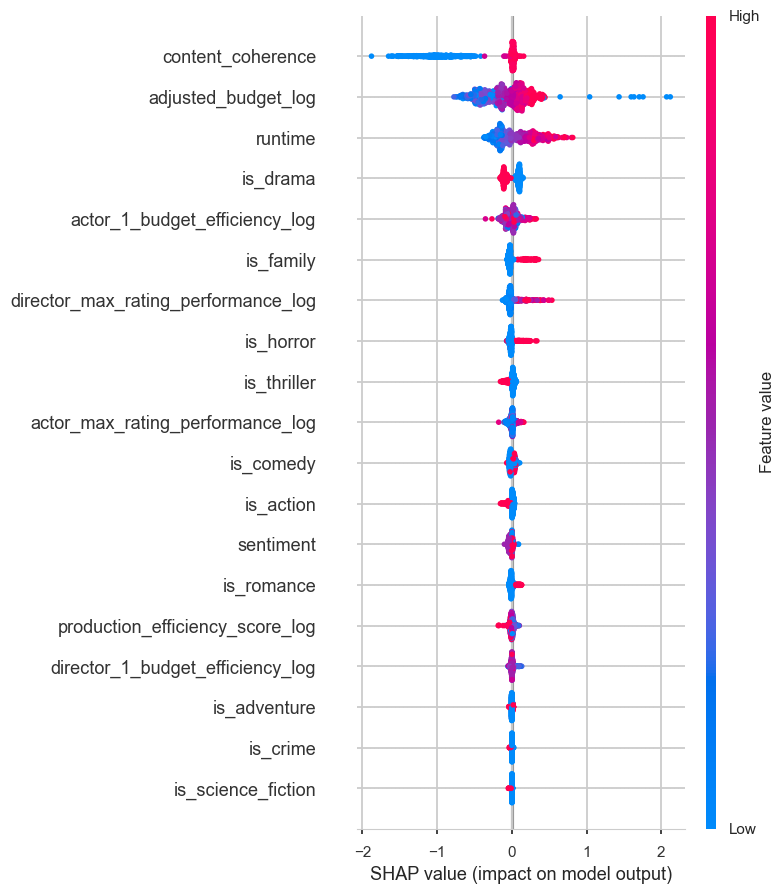

In [ ]:
plt.figure(figsize=(10, 8))
shap.summary_plot(
        pipeline.results['CatBoost']['shap_values'],
        pipeline.results['CatBoost']['shap_data'],
        feature_names=pipeline.features,
        show=False
)
plt.tight_layout()
plt.savefig('catboost_shap_summary.png')
plt.show()
    

In [ ]:
def plot_shap_dependencies(results, model='CatBoost', n_features=10, interaction=None):


    # Extract SHAP data
    shap_values = results[model]['shap_values']
    X = results[model]['shap_data']
    features = X.columns.tolist()
    
    # Get top features by importance
    importance = np.abs(shap_values).mean(0)
    top_idx = np.argsort(-importance)[:min(n_features, len(features))]
    top_features = [features[i] for i in top_idx]
    
    fig, axes = plt.subplots(5, 2, figsize=(20, 15))
    axes = axes.flatten()
    for i, feature in enumerate(top_features):
        if i >= len(axes): break
        plt.sca(axes[i])
        idx = features.index(feature)
        
        if interaction and interaction in features:
            shap.dependence_plot(idx, shap_values, X, 
                interaction_index=features.index(interaction), 
                ax=axes[i], show=False)
            axes[i].set_title(f"{feature} (colored by {interaction})")
        else:
            shap.dependence_plot(idx, shap_values, X, ax=axes[i], show=False)
            axes[i].set_title(feature)

    for i in range(len(top_features), len(axes)):
        fig.delaxes(axes[i])
        
    plt.suptitle(f"SHAP Dependency Plots - {model}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    return fig

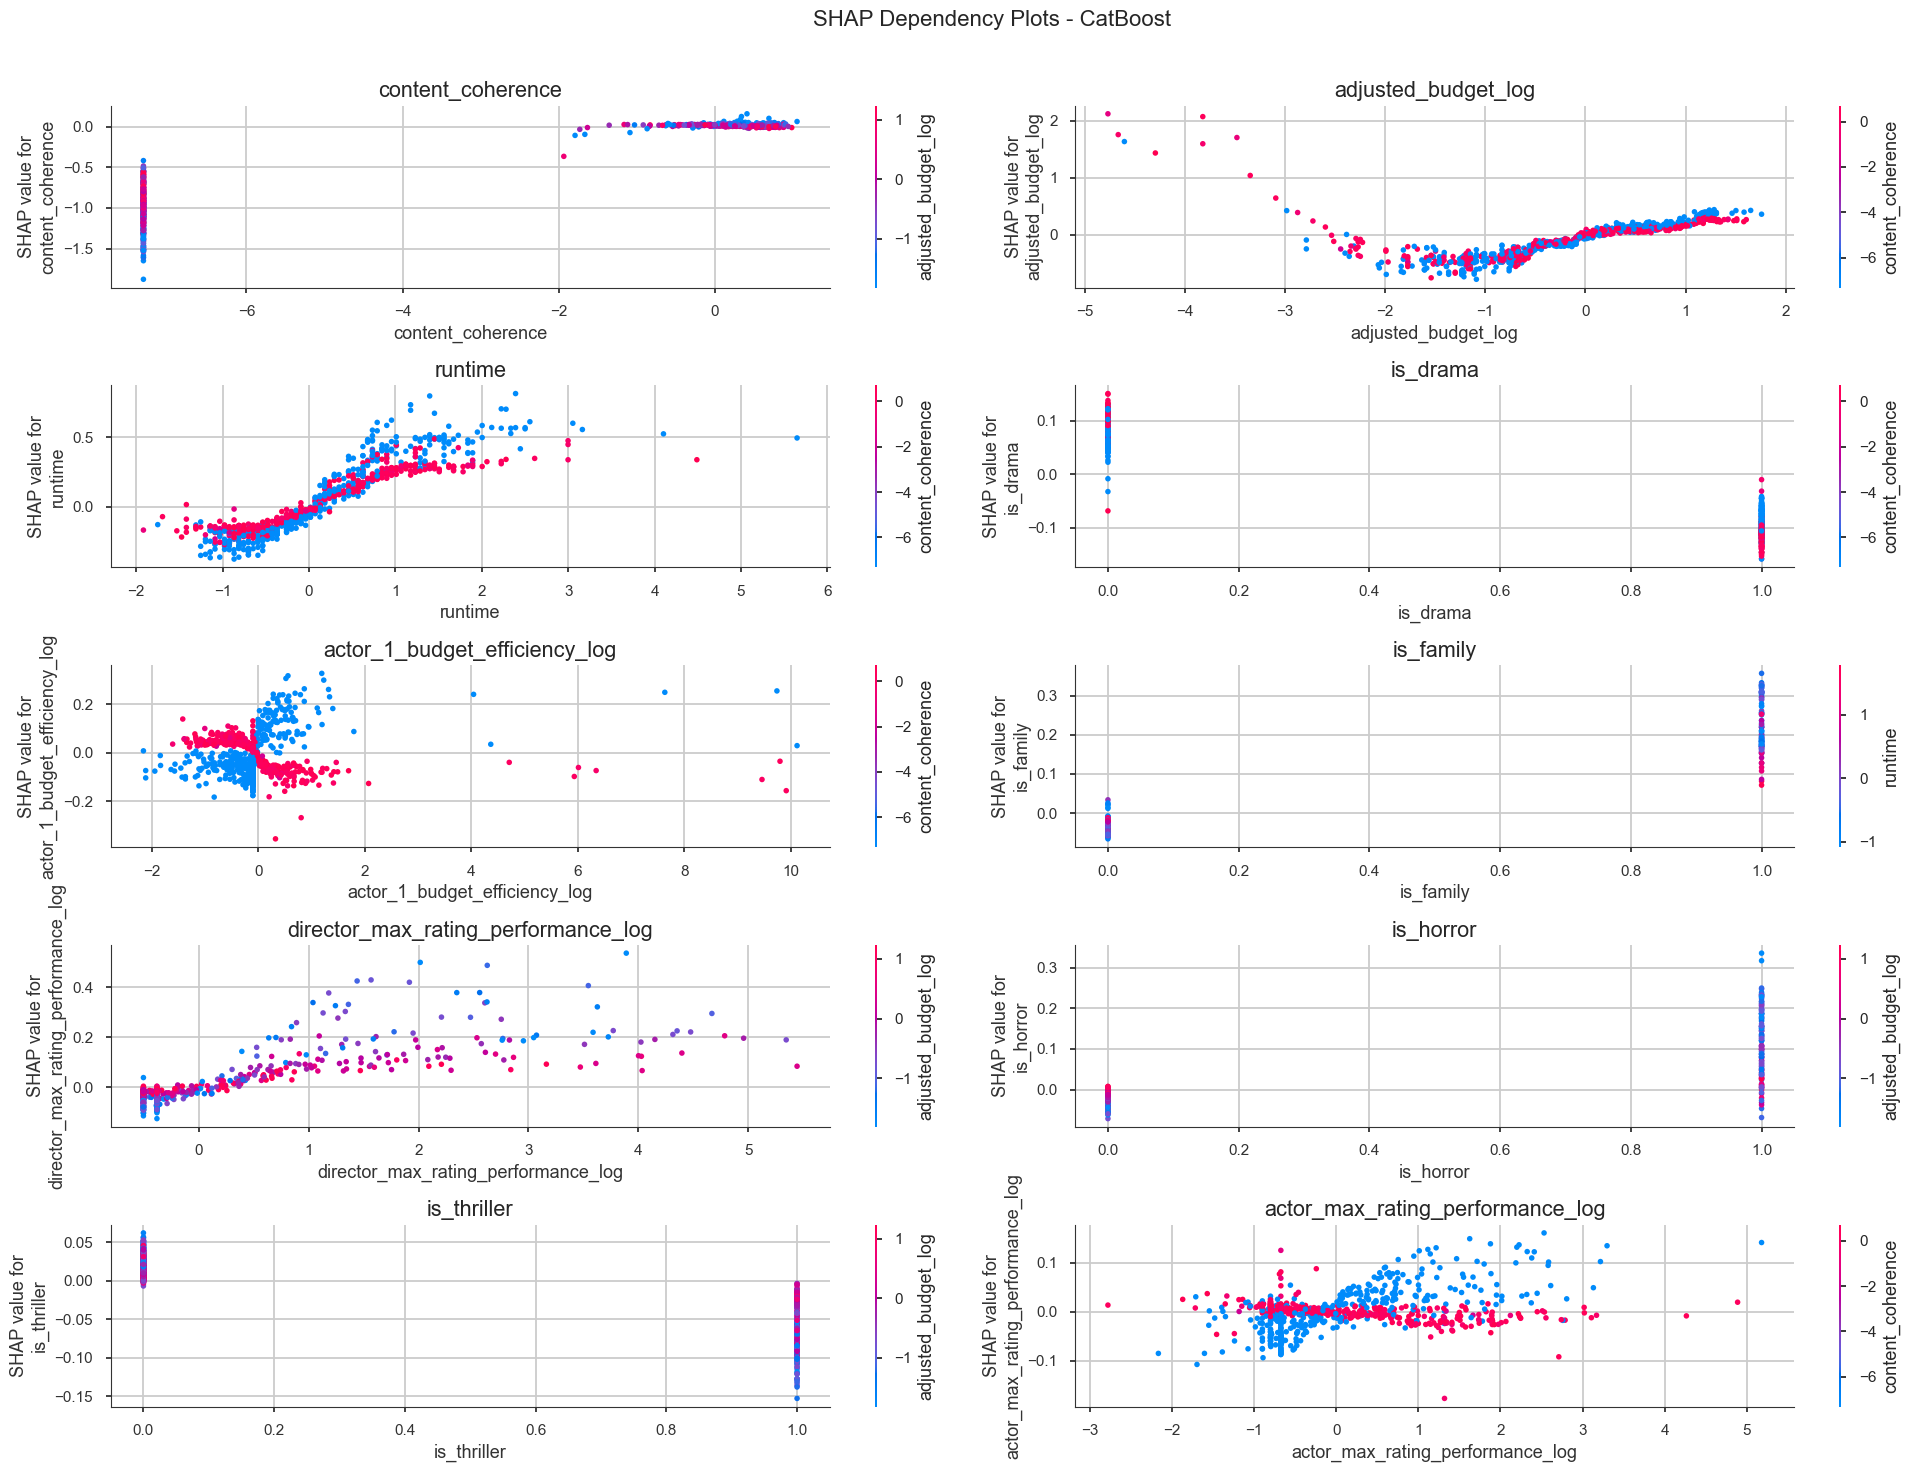

In [24]:

fig = plot_shap_dependencies(results, interaction='budget')